In [19]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../..')
from funcs.stats import get_stats
from funcs.xarray_tools import find_cor_ts
from funcs.plotting import map_grid_clean, add_text
from constants.colors import loc_colors

from taus import decorrelation_temporal_model

In [21]:
# fps = list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*_tau.nc'))
fps = list(Path('/bsuhome/zacharykeskinen/scratch/coherence/uavsar').glob('*_tau.nc'))
dss = {fp.stem.replace('_v3_tau',''): xr.open_dataset(fp) for fp in fps}
df = pd.read_csv(Path('/bsuhome/zacharykeskinen/uavsar-coherence/data/snotel').joinpath('snotel_uavsar_diffs_v2.csv'))
df = df[df['pol'] == 'VV']
df['ave_swe'] = (df.swe_t1 + df.swe_t2)/2

fig_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/snow/')

out_dir = Path('/bsuhome/zacharykeskinen/scratch/coherence/model')
res = np.fromfile(out_dir.joinpath('model_cors_dswes_cummelts_swes.npy'))
cors, dswes, cummelts, swes = res.reshape(4, -1)

In [101]:
taus = np.array([])
sds = np.array([])
for stem, ds in dss.items():
    if 'sd' not in ds.data_vars: continue
    print(stem)
    ds = ds[['curvefit_coefficients','sd']].sel(pol = 'VV').where((~ds['sd'].mean('time').isnull())).dropna('x', how = 'all').dropna('y', how = 'all') # & (ds['tree_perc'] < 10) & (ds["inc"] < np.deg2rad(60))& (ds["inc"] > np.deg2rad(30)))
    for heading in ds.heading.values:
        print(heading)
        for time in ds.time.values:
            coef = ds['curvefit_coefficients'].sel(heading = heading)
            cor12 = decorrelation_temporal_model(12, coef.sel(param = 'gamma_inf'), coef.sel(param = 'tau'))
            cor12 = cor12.values.ravel()
            print(time)
            sd = ds['sd'].sel(time = time).values.ravel()
            sd, cor12 = sd[(~np.isnan(sd)) & (~np.isnan(cor12))], cor12[(~np.isnan(sd)) & (~np.isnan(cor12))]
            taus = np.concatenate([cor12, taus])
            sds = np.concatenate([sd, sds])


rockmt
141
2021-03-19T00:00:00.000000000
321
2021-03-19T00:00:00.000000000
fraser
52
2021-03-19T00:00:00.000000000
2020-02-11T00:00:00.000000000
233
2021-03-19T00:00:00.000000000
2020-02-11T00:00:00.000000000
lowman
52
2020-02-01T00:00:00.000000000
2021-03-01T00:00:00.000000000
232
2020-02-01T00:00:00.000000000
2021-03-01T00:00:00.000000000
stlake
91
2021-03-18T00:00:00.000000000
271
2021-03-18T00:00:00.000000000


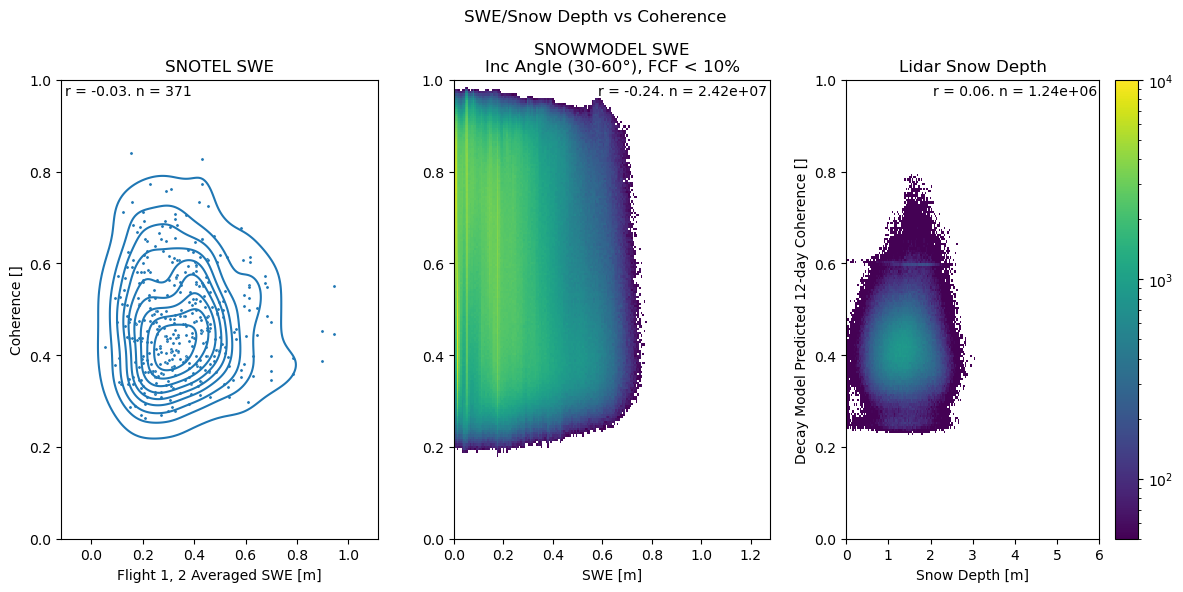

In [109]:
fig_dir = Path('/bsuhome/zacharykeskinen/uavsar-coherence/figures/snow')

fig, axes= plt.subplots(1, 3 , figsize = (12, 6))

ax = axes[0]
sns.kdeplot(x = 'ave_swe', y = 'cor', data = df, ax = ax, fill= False)
sns.scatterplot(x = 'ave_swe', y = 'cor', data = df, ax= ax, s = 5)
# import matplotlib.patches as  mpatches
# handles = [mpatches.Patch(facecolor=plt.cm.Reds(100), label="<7 days"),
        #    mpatches.Patch(facecolor=plt.cm.Blues(100), label="7-14 days")]
# ax.legend(handles=handles)
rmse, r, n = get_stats(df.ave_swe, df.cor)
add_text(f'r = {r:.2f}. n = {n:.0f}', ax, 'upper left')
ax.set_title('SNOTEL SWE')
ax.set_xlabel('Flight 1, 2 Averaged SWE [m]')

ax = axes[1]
h = ax.hist2d(swes, cors, bins = 200, norm=mpl.colors.LogNorm(vmin = 50, vmax = 10000), cmin = 50)
# fig.colorbar(h[3], ax = ax)
rmse, r, n = get_stats(swes, cors)
add_text(f'r = {r:.2f}. n = {n:.2e}', ax, 'upper right')
ax.set_title('SNOWMODEL SWE\nInc Angle (30-60°), FCF < 10%')
ax.set_xlabel('SWE [m]')

ax = axes[2]
h = ax.hist2d(sds, taus, bins = 200, norm = mpl.colors.LogNorm(vmin = 50, vmax = 10000), range = [[0, 6], [0, 1]], cmin = 20,)
fig.colorbar(h[3], ax = ax)
ax.set_xlabel('Snow Depth [m]')
rmse, r, n = get_stats(sds, taus)
add_text(f'r = {r:.2f}. n = {n:.2e}', ax, 'upper right')
ax.set_title('Lidar Snow Depth')

for ax in axes[:2]:
        ax.set_ylabel('')
        ax.set_ylim(0, 1)
axes[0].set_ylabel('Coherence []')
axes[2].set_ylabel('Decay Model Predicted 12-day Coherence []')

plt.suptitle('SWE/Snow Depth vs Coherence')
plt.tight_layout()
plt.savefig(fig_dir.joinpath('SWE_cor.png'))